In [334]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt

In [335]:
data = pd.read_csv('crime_stations_transformed2.csv', sep = ',', header = 0)

crimes = pd.DataFrame(data)

In [336]:
crimes['Weapon'] = crimes['Weapon'].fillna('None')
crimes['Age_Category'] = crimes['Age_Category'].fillna('0-18')
crimes = crimes[['Month','Daytime','Race','Age_Category','Gender','Weapon','PremiseType','Old_District','distance_to_police','Police_in_neigh','Description','Neighborhood']]

In [337]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='error')

In [338]:
to_encode = crimes[['Daytime','PremiseType','Weapon','Gender','Month','Race','Age_Category','Police_in_neigh','Old_District']]


In [339]:
encoded = encoder.fit_transform(to_encode)

In [340]:
encoded_column_names = [f'{col}_{cat}' for i, col in enumerate(to_encode.columns) for cat in encoder.categories_[i]]

In [341]:
encoded_df = pd.DataFrame(encoded, columns=encoded_column_names)
crimes[encoded_column_names] = encoded_df
##encoded_column_names.append('distance_to_police')
encoded_column_names


C:\Users\janho\AppData\Local\Temp\ipykernel_12632\640597182.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crimes[encoded_column_names] = encoded_df
C:\Users\janho\AppData\Local\Temp\ipykernel_12632\640597182.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  crimes[encoded_column_names] = encoded_df
C:\Users\janho\AppData\Local\Temp\ipykernel_12632\640597182.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

['Daytime_Afternoon',
 'Daytime_Early Morning',
 'Daytime_Evening',
 'Daytime_Morning',
 'Daytime_Night',
 'PremiseType_APARTMENT',
 'PremiseType_BANK/FINANCIAL INST',
 'PremiseType_BAR/RESTAURANT',
 'PremiseType_BARBER/BEAUTY SHOP',
 'PremiseType_BOAT',
 'PremiseType_BRIDGE-PIERS-DOCKS',
 'PremiseType_BUS/AUTO',
 'PremiseType_BUS/CAB/CAR',
 'PremiseType_CAR  REPAIR SHOP',
 'PremiseType_CARRY OUT',
 'PremiseType_COMMON BUSINESS',
 'PremiseType_CONSTRUCTION',
 'PremiseType_COURT HOUSE',
 'PremiseType_DRIVEWAY',
 'PremiseType_DWELLING',
 'PremiseType_EVENT',
 'PremiseType_FIRE DEPARTMENT',
 'PremiseType_GARAGE',
 'PremiseType_GAS STATION',
 'PremiseType_HARBOR',
 'PremiseType_HARDWARE/BLDG. SUP.',
 'PremiseType_HOTEL/MOTEL',
 'PremiseType_LAUNDRY/CLEANRS/SHOE',
 'PremiseType_LIBRARY',
 'PremiseType_LIGHT RAIL',
 'PremiseType_MAILBOX-STREET/RES.',
 'PremiseType_MANUFACTURING PLANT',
 'PremiseType_MARKET STALLS',
 'PremiseType_MEDICAL CENTER',
 'PremiseType_MINI STORAGE LOCKERS',
 'Premise

In [342]:
y = crimes.Description

x = crimes[encoded_column_names]


In [343]:
train_x, test_x,train_y,test_y = train_test_split(x,y,stratify = y,test_size=0.20)


In [344]:
tree1 = DecisionTreeClassifier(criterion = 'gini', max_depth=13, min_samples_leaf=20, min_samples_split=20)

tree1 = tree1.fit(train_x, train_y)



In [345]:
scores = tree1.score(test_x, test_y)
scores

0.5332505127649285

In [346]:
import pandas as pd
predicted = pd.DataFrame(tree1.predict(test_x))
joined_df = pd.concat([test_y.reset_index(drop=True), predicted], axis=1)
joined_df.columns = ['Description', 'Predicted']
joined_df = pd.DataFrame(joined_df)
joined_df


,Description,Predicted
0,LARCENY,LARCENY FROM AUTO
1,ROBBERY,ROBBERY
2,COMMON ASSAULT,BURGLARY
3,BURGLARY,BURGLARY
4,AGG. ASSAULT,AGG. ASSAULT
...,...,...
119933,BURGLARY,LARCENY
119934,ROBBERY,ROBBERY
119935,AGG. ASSAULT,AGG. ASSAULT
119936,LARCENY,LARCENY


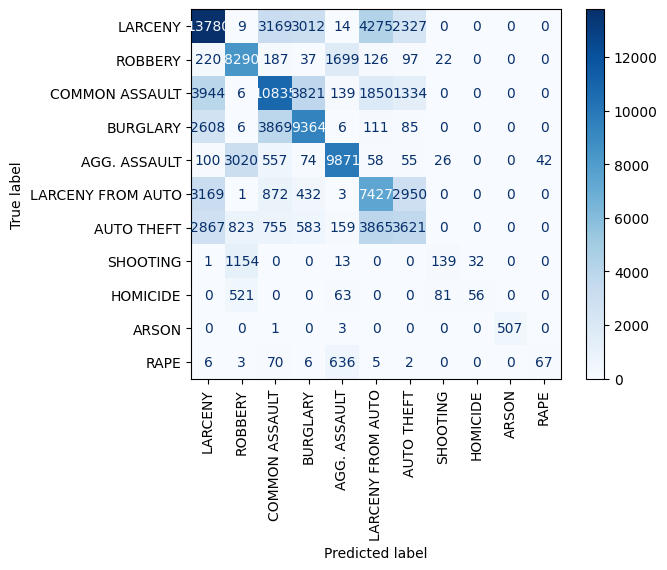

In [358]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(test_y, predicted,labels = list(test_y.unique()))
cmtx = pd.DataFrame(
    confusion_matrix(test_y, predicted, labels=list(test_y.unique())), 
    index=['{:}'.format(x) for x in list(test_y.unique())], 
    columns=['{:}'.format(x) for x in list(test_y.unique())])


cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cmtx.index, )
cm_display.plot(cmap='Blues')
plt.xticks(rotation = 'vertical')
plt.show()


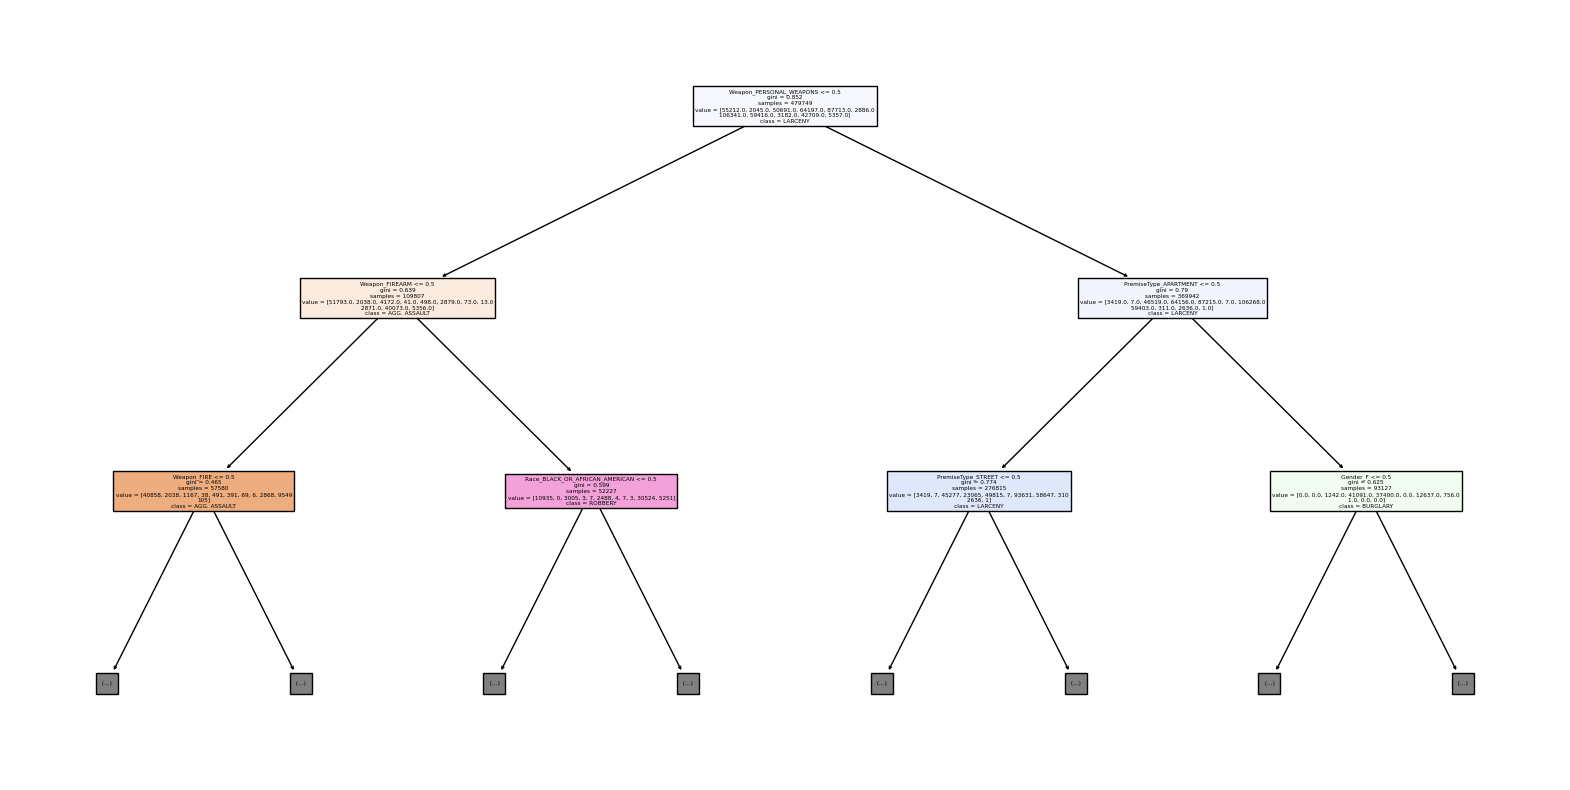

In [349]:
plt.figure(figsize=(20,10))
tree.plot_tree(tree1, filled=True, feature_names=encoded_column_names, class_names=tree1.classes_, max_depth=2)
plt.show()


In [350]:
from sklearn.tree import export_text
tree_rules = export_text(tree1, feature_names=list(train_x.columns))
print(tree_rules)

|--- Weapon_PERSONAL_WEAPONS <= 0.50
|   |--- Weapon_FIREARM <= 0.50
|   |   |--- Weapon_FIRE <= 0.50
|   |   |   |--- Weapon_HANDGUN <= 0.50
|   |   |   |   |--- Weapon_HANDS <= 0.50
|   |   |   |   |   |--- PremiseType_STORE <= 0.50
|   |   |   |   |   |   |--- PremiseType_APARTMENT <= 0.50
|   |   |   |   |   |   |   |--- Weapon_KNIFE <= 0.50
|   |   |   |   |   |   |   |   |--- PremiseType_DWELLING <= 0.50
|   |   |   |   |   |   |   |   |   |--- Gender_F <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- PremiseType_OTHER/RESIDENTIAL <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- PremiseType_OTHER/RESIDENTIAL >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- Gender_F >  0.50
|   |   |   |   |   |   |   |   |   |   |--- Race_BLACK_OR_AFRICAN_AMERICAN <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch 

In [351]:
list(test_y.unique())

['LARCENY',
 'ROBBERY',
 'COMMON ASSAULT',
 'BURGLARY',
 'AGG. ASSAULT',
 'LARCENY FROM AUTO',
 'AUTO THEFT',
 'SHOOTING',
 'HOMICIDE',
 'ARSON',
 'RAPE']